## Are the key socio-demographic and economic  characteristics of individuals who lose their homes different for Hillsborough County compared to New York City?
Compare evictions in Hillsborough County to NYC using DP04 variables (see census data dictionary)

(and other things!)

### To Do
- Create heatmap of evictions in Tableau
- Merge with evictions dataset
- Find correlation coefficient between each ACS Socio-Economic factor and eviction rate per subdivision

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [32]:
import pandas as pd
import numpy as np
import seaborn as sns

#import plotly.express as px
#import matplotlib.pyplot as plt


pd.options.display.max_columns = None

### Load data

In [3]:
# Load data

# acs
df_data_dict = pd.read_csv("../../data/acs/data_dictionary.csv")
df_hillsborough_acs5 = pd.read_csv("../../data/acs/hillsborough_acs5-2018_census.csv")
df_nyc_acs5 = pd.read_csv("../../data/acs/nyc_acs5-2018_census.csv")

# processed
#df_hillsborough_fl_processed = pd.read_csv("../../data/processed/hillsborough_fl_processed_2017_to_2019_20210225.csv")
#df_hillsborough_fl_processed_timeseries = pd.read_csv("../../data/processed/hillsborough_fl_processed_timeseries_2017_to_2019_20210225.csv")
#df_nyc_processed = pd.read_csv("../../data/processed/nyc_processed_2017_to_2019_20210225.csv")
#df_nyc_processed_timeseries = pd.read_csv("../../data/processed/nyc_processed_timeseries_2017_to_2019_20210225.csv")

# raw
df_hillsborough_county_evictions_geocoded = pd.read_csv("../../data/raw/hillsborough_county_evictions_geocoded.csv")
df_hillsborough_county_mortgage_foreclosures_geocoded = pd.read_csv("../../data/raw/hillsborough_county_mortgage_foreclosures_geocoded.csv")
df_hillsborough_county_tax_liens_geocoded = pd.read_csv("../../data/raw/hillsborough_county_tax_liens_geocoded.csv")
df_nyc_evictions_geocoded = pd.read_csv("../../data/raw/nyc_evictions_geocoded.csv")

# tax_lien_prediction
#df_nyc_census_tracts_to_neighborhoods = pd.read_excel("../../data/tax_lien_prediction/nyc_census_tracts_to_neighborhoods.xlsx")
#df_nyc_tax_lien_sale_list = pd.read_csv("../../data/tax_lien_prediction/nyc_tax_lien_sale_list.csv")
#df_zillow_nyc = pd.read_excel("../../data/tax_lien_prediction/zillow_nyc_neighborhoods_typical_home_values_time_series.xlsx")

C:\Users\zrowl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (5,21,22,28,29,30,33,34,40) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Create new datasets

In [4]:
# combine hb and nyc data with locale column to identify them
df_hillsborough_acs5['locale'] = 'hb'
df_nyc_acs5['locale'] = 'nyc'

df_acs5 = pd.concat([df_hillsborough_acs5, df_nyc_acs5], axis=0)

In [6]:
# get mapping dict
df_data_dict.set_index('variable')
df_data_dict['variable_label'] = df_data_dict['variable'] + '+' + df_data_dict['label']
data_dict = df_data_dict[['variable','variable_label']].set_index('variable').to_dict()['variable_label']
data_dict['index'] = 'index'

In [7]:
# apply mapping
# mapping is in the format: VARIABLE+LABEL (see below the headers of the cell below)
df_DP = df_acs5.rename(columns=data_dict)

In [11]:
# examine the combined data
df_DP.head()

index  \
0  Census Tract 139.19, Hillsborough County, Flor...   
1  Census Tract 139.20, Hillsborough County, Flor...   
2  Census Tract 139.21, Hillsborough County, Flor...   
3  Census Tract 10.01, Hillsborough County, Flori...   
4  Census Tract 53.01, Hillsborough County, Flori...   

   DP02_0001E+Estimate!!HOUSEHOLDS BY TYPE!!Total households  \
0                                               2198           
1                                               1228           
2                                               1323           
3                                               1395           
4                                               2077           

   DP02_0001PE+Percent Estimate!!HOUSEHOLDS BY TYPE!!Total households  \
0                                               2198                    
1                                               1228                    
2                                               1323                    
3                                               1395                    
4                                               2077                    

   DP02_0002E+Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)  \
0                                               1830                                         
1                                                967                                         
2                                               1229                                         
3                                               1042                                         
4                                                507                                         

   DP02_0002PE+Percent Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)  \
0                                               83.3                                                  
1                                               78.7                                                  
2                                               92.9                                                  
3                                               74.7                                                  
4                                               24.4                                                  

   DP02_0003E+Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!With own children of the householder under 18 years  \
0                                                850                                                                                              
1                                                454                                                                                              
2                                                789                                                                                              
3                                                572                                                                                              
4                                                104                                                                                              

   DP02_0003PE+Percent Estimate!!HOUSEHOLDS BY TYPE!!Total households!!Family households (families)!!With own children of the householder under 18 years  \
0                                               38.7                                                                                                       
1                                               37.0                                                                                                       
2                                               59.6                                                                                                       
3                                               41.0                                                                                                       
4                                      

In [13]:
# get the field names
names_DP = list(df_DP.columns)

In [14]:
# drop columns with negative values
# NOTE: There may be some that are non-negative in NYC vs HB and vice versa, I didn't check it. This will remove any with negative column totals.
#       But as we are comparing the two I think its better to use the same factors anyway.

df_DP_nums = df_DP.drop(columns=['index', 'locale'])
df_DP_nums_total = df_DP_nums.sum()
negative_cols = df_DP_nums_total.where(df_DP_nums_total < 0).dropna().index.to_list()

df_DP_pos = df_DP.drop(negative_cols, axis=1)

In [15]:
# get the positive field names (i.e. column headers for columns with non-negative values)
names_DP_pos = list(df_DP_pos.columns)

In [17]:
# seperate the E and PE datasets (estimate and percent estimate)
names_DP_pos_PE = [name for name in names_DP_pos if "PE+" in name]
names_DP_pos_E = list(set(names_DP_pos)-set(names_DP_pos_PE)-set(['index','locale']))

df_DP_pos_PE = df_DP_pos.drop(names_DP_pos_E, axis=1)
df_DP_pos_E = df_DP_pos.drop(names_DP_pos_PE, axis=1)

In [57]:
# split the E and PE datasets into nyc and hb

# nyc
df_nyc_pos_PE = df_DP_pos_PE.loc[df_DP_pos_PE['locale'] == 'nyc']
df_nyc_pos_E = df_DP_pos_E.loc[df_DP_pos_E['locale'] == 'nyc']

# nyc DP categories
df_nyc_pos_E_DP02 = df_nyc_pos_E.filter(regex='DP02')
df_nyc_pos_E_DP03 = df_nyc_pos_E.filter(regex='DP03')
df_nyc_pos_E_DP04 = df_nyc_pos_E.filter(regex='DP04')
df_nyc_pos_E_DP05 = df_nyc_pos_E.filter(regex='DP05')

# hb
df_hb_pos_PE = df_DP_pos_PE.loc[df_DP_pos_PE['locale'] == 'hb']
df_hb_pos_E = df_DP_pos_E.loc[df_DP_pos_E['locale'] == 'hb']

# hb DP categories
df_hb_pos_E_DP02 = df_hb_pos_E.filter(regex='DP02')
df_hb_pos_E_DP03 = df_hb_pos_E.filter(regex='DP03')
df_hb_pos_E_DP04 = df_hb_pos_E.filter(regex='DP04')
df_hb_pos_E_DP05 = df_hb_pos_E.filter(regex='DP05')

### Export data for Tableau etc.

In [ ]:
# export raw, combined data for tableau
# df_acs5.to_csv("processed_data/acs5_raw_combined.csv", index=False)

# for parameters
# names_acs5 = list(df_acs5.columns)
# with open('processed_data/acs5_raw_headers.txt', mode='wt', encoding='utf-8') as myfile:
#     myfile.write('\n'.join(names_acs5))

# export renamed dataset
# df_DP.to_csv("processed_data/acs5_renamed_combined.csv", index=False)




### Analysis
I was trying to compare the correlation matricies for NYC and HB to see if different SE factors are correlated the same in both locales, but this needs to be combined with the eviction data somehow to be useful.

Idea: Hexbin map within the county, bin the eviction coordinates into the hexes with their nearby census tracts / counties? Then we can adjust the resolution to greater than tract/county level.

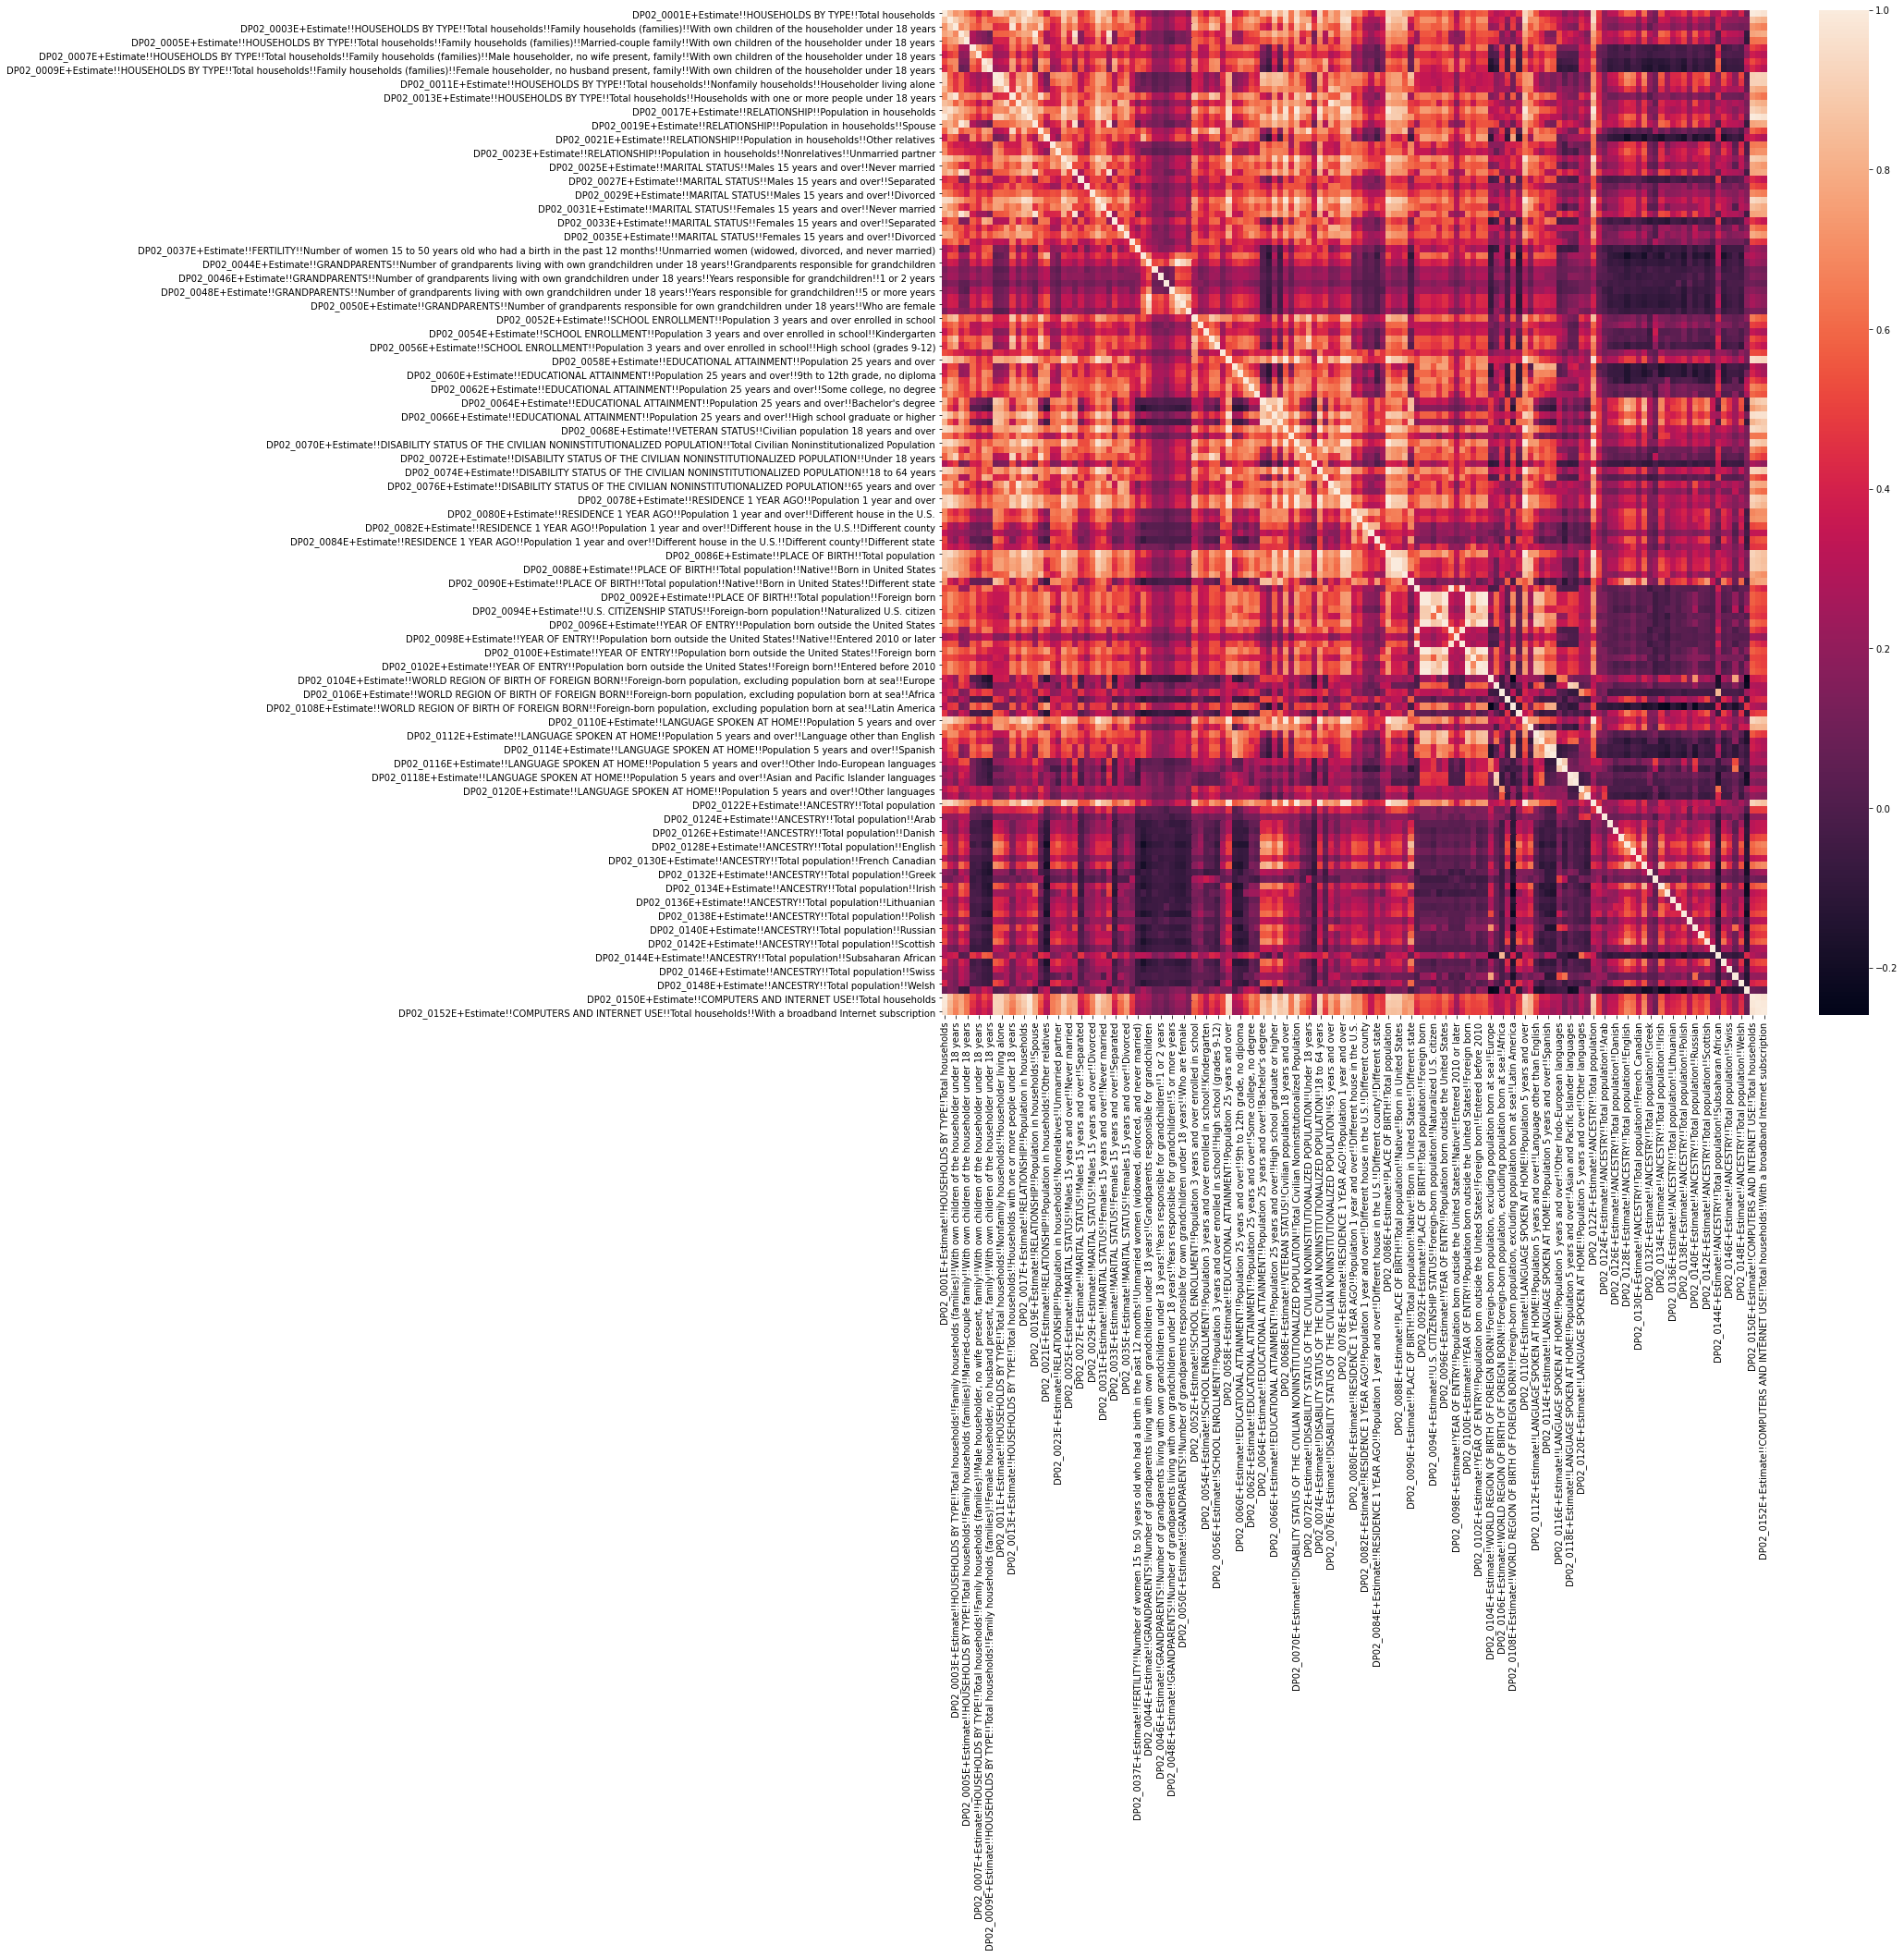

In [58]:
# correlation matricies
nyc_cormat = df_nyc_pos_E.drop(['index','locale','GEOID'], axis=1).corr()
hb_cormat = df_hb_pos_E.drop(['index','locale','GEOID'], axis=1).corr()

nyc_DP02_cormat = df_nyc_pos_E_DP02.corr()
nyc_DP03_cormat = df_nyc_pos_E_DP03.corr()
nyc_DP04_cormat = df_nyc_pos_E_DP04.corr()
nyc_DP05_cormat = df_nyc_pos_E_DP05.corr()

hb_DP02_cormat = df_hb_pos_E_DP02.corr()
hb_DP03_cormat = df_hb_pos_E_DP03.corr()
hb_DP04_cormat = df_hb_pos_E_DP04.corr()
hb_DP05_cormat = df_hb_pos_E_DP05.corr()

# difference between nyc and hb
diff_cormat = nyc_cormatt - hb_cormatt

# heatmap - idea to use seaborn admittedly stolen from snnehete's work!
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(nyc_DP02_cormat, ax = ax, linewidths = 0)

In [46]:
# cite: https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on

# Select upper triangle of correlation matrix
upper = diff_cormat.where(np.triu(np.ones(diff_cormat.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
high_corr = [column for column in upper.columns if any(upper[column] > 0.7)]

# Drop features 
#df.drop(to_drop, axis=1, inplace=True)

high_corr

['DP03_0021E+Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Public transportation (excluding taxicab)',
 'DP03_0024E+Estimate!!COMMUTING TO WORK!!Workers 16 years and over!!Worked at home',
 'DP03_0027E+Estimate!!OCCUPATION!!Civilian employed population 16 years and over!!Management, business, science, and arts occupations',
 'DP03_0058E+Estimate!!INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Total households!!$75,000 to $99,999',
 'DP03_0059E+Estimate!!INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Total households!!$100,000 to $149,999',
 'DP03_0060E+Estimate!!INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Total households!!$150,000 to $199,999',
 'DP03_0061E+Estimate!!INCOME AND BENEFITS (IN 2018 INFLATION-ADJUSTED DOLLARS)!!Total households!!$200,000 or more',
 'DP03_0105E+Estimate!!HEALTH INSURANCE COVERAGE!!Civilian noninstitutionalized population!!Civilian noninstitutionalized population 19 to 64 years!!In labor force!!Employed!!With he

In [100]:
# snips
"""

# get the field names
names_DP = list(df_DP.columns)

len(names_DP)


# combine hb and nyc data
# df_hb_DP04['locale'] = 'hb'
# df_nyc_DP04['locale'] = 'nyc'

# df_DP04 = pd.concat([df_hb_DP04, df_nyc_DP04], axis=0)


# restrict to DP04
# df_hb_DP04 = pd.concat([df_hb['index'] , df_hb.filter(regex='DP04')], axis=1)
# df_nyc_DP04 = pd.concat([df_nyc['index'] , df_nyc.filter(regex='DP04')], axis=1)


# create simple figs

# ax = df_hb.plot.barh(x='index', y='DP02_0001E+Estimate!!HOUSEHOLDS BY TYPE!!Total households', figsize=(100,900))

df = px.data.iris() # iris is a pandas DataFrame
fig = px.scatter(df_DP04,
                 x='DP04_0001PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units',
                 y='DP04_0002PE+Percent Estimate!!HOUSING OCCUPANCY!!Total housing units!!Occupied housing units',
                 size='DP04_0001E+Estimate!!HOUSING OCCUPANCY!!Total housing units',
                 color='locale')
fig.show()

#fig = px.scatter(x=df_hb.iloc[:,1], y=df_hb.iloc[:,3])
#fig.show()


print(list(set(['a','b','c','d'])-set(['a','b'])))


#list(df_hb_DP04.columns)
#df_hillsborough_acs5['index']
#pd.concat([df_hillsborough_acs5['index'] , df_hillsborough_acs5.rename(columns=data_dict).filter(regex='DP04')])


#df_data_dict_DP004 = df_data_dict[df_data_dict['variable_cat'].str.match('DP04')]
#df_data_dict['variable_cat'] = df_data_dict['variable'].str.split('_', expand=True)[0]


json_hillsborough_evict = df_hillsborough_county_evictions_geocoded.to_json(orient="split")
hb_parsed = json.loads(json_hillsborough_evict)

with open('json_hillsborough_evict.json', 'w') as json_file:
    json.dump(hb_parsed, json_file)
"""

['c', 'd']


'\n\n#list(df_hb_DP04.columns)\n#df_hillsborough_acs5[\'index\']\n#pd.concat([df_hillsborough_acs5[\'index\'] , df_hillsborough_acs5.rename(columns=data_dict).filter(regex=\'DP04\')])\n\n\n#df_data_dict_DP004 = df_data_dict[df_data_dict[\'variable_cat\'].str.match(\'DP04\')]\n#df_data_dict[\'variable_cat\'] = df_data_dict[\'variable\'].str.split(\'_\', expand=True)[0]\n\n\njson_hillsborough_evict = df_hillsborough_county_evictions_geocoded.to_json(orient="split")\nhb_parsed = json.loads(json_hillsborough_evict)\n\nwith open(\'json_hillsborough_evict.json\', \'w\') as json_file:\n    json.dump(hb_parsed, json_file)\n'